<a href="https://colab.research.google.com/github/littlekii/DPBBP/blob/main/langevin_hetero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/JavierAntoran/Bayesian-Neural-Networks.git
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip3 install GPy
import pandas as pd
import zipfile
import urllib.request
import GPy
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from torch.optim.sgd import SGD
from sklearn.model_selection import KFold

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from google.colab import files
%config InlineBackend.figure_format = 'svg'

Cloning into 'Bayesian-Neural-Networks'...
remote: Enumerating objects: 369, done.
remote: Total 369 (delta 0), reused 0 (delta 0), pack-reused 369
Receiving objects: 100% (369/369), 15.98 MiB | 17.50 MiB/s, done.
Resolving deltas: 100% (191/191), done.
ERROR: torch-0.4.1-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.
     |████████████████████████████████| 962kB 3.3MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
  Created wheel for GPy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2564977 sha256=f05beea25382bcde59dcb855afb9e8f61c0b9417623ff560ae8225fdbee92bb2
  Stored in directory: /root/.cache/pip/wheels/23/99/8d/d0c3dee7db4af58190cde6abdb45e6a7ded2f9f01ff528dd0f
  Created wheel for paramz: filename=paramz-0.9.5-cp37-none-any.whl size=102566 sha256=629db8efc0b508ede3d64964e18ef48ca5e4be0b68ec6b65bc148d4ba57f799a
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPy

In [ ]:
torch.cuda.device(0)
torch.cuda.get_device_name(torch.cuda.current_device())

'Tesla P100-PCIE-16GB'

In [ ]:
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

## SGLD help functions

In [ ]:
class Langevin_SGD(Optimizer):

    def __init__(self, params, lr, weight_decay=0, nesterov=False):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, weight_decay=weight_decay)
        
        super(Langevin_SGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    def step(self, closure=None):
        
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            
            weight_decay = group['weight_decay']
            
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                
                if len(p.shape) == 1 and p.shape[0] == 1:
                    p.data.add_(-group['lr'], d_p)
                    
                else:
                    if weight_decay != 0:
                        d_p.add_(weight_decay, p.data)

                    unit_noise = Variable(p.data.new(p.size()).normal_())

                    p.data.add_(-group['lr'], 0.5*d_p + unit_noise/group['lr']**0.5)

        return loss

In [ ]:
def log_gaussian_loss(output, target, sigma, no_dim):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma)
    
    return - (log_coeff + exponent).sum()


def get_kl_divergence(weights, prior, varpost):
    prior_loglik = prior.loglik(weights)
    
    varpost_loglik = varpost.loglik(weights)
    varpost_lik = varpost_loglik.exp()
    
    return (varpost_lik*(varpost_loglik - prior_loglik)).sum()


class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()

In [ ]:
class Langevin_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units):
        super(Langevin_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        
        # network with two hidden and one output layer
        self.layer1 = nn.Linear(input_dim, num_units)
        self.layer2 = nn.Linear(num_units, num_units)
        self.layer3 = nn.Linear(num_units, 2*output_dim)
        
        self.activation = nn.ReLU(inplace = True)

    
    def forward(self, x):
        
        x = x.view(-1, self.input_dim)
        
        x = self.layer1(x)
        x = self.activation(x)
      
        
        x = self.layer2(x)
        x = self.activation(x)

        y = self.layer3(x)
        
        return y

In [ ]:
class Langevin_Wrapper:
    def __init__(self, network, learn_rate, batch_size, no_batches, weight_decay):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = network
        self.network.cuda()
        
        self.optimizer = Langevin_SGD(self.network.parameters(), lr=self.learn_rate, weight_decay=weight_decay)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        
        output = self.network(x)
        loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)
        
        loss.backward()
        self.optimizer.step()

        return loss,output[:, :1]
    
    
    def test_loss(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)
        
        output = self.network(x)
        loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)

        return loss

In [ ]:
def eval_ensemble(x, y, ensemble):
    
    x, y = to_variable(var=(x, y), cuda=True)
        
    means, stds = [], []
    for net in ensemble:
        output = net(x)
        means.append(output[:, :1, None])
        stds.append(output[:, 1:, None].exp())
            
    means, stds = torch.cat(means, 2), torch.cat(stds, 2)
    mean = means.mean(dim=2)
    std = (means.var(dim=2) + stds.mean(dim=2)**2)**0.5
    loss = log_gaussian_loss(mean, y, std, 1)/len(x)
    
    rmse = ((mean - y)**2).mean()**0.5

    return loss, rmse

## SGLD Gaussian Prior Hetero

 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  161.501
Epoch:   50, Train loss =  441.799
Epoch:  100, Train loss =  379.827
Epoch:  150, Train loss =  138.985
Epoch:  200, Train loss =  124.910
Using 1 networks for prediction


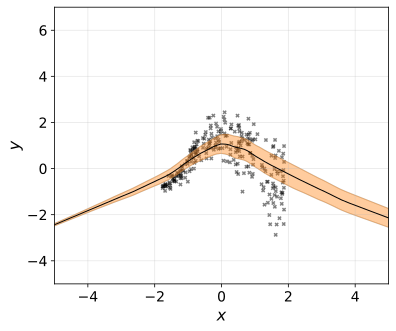

 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  119.498
Epoch:   50, Train loss =  119.577
Epoch:  100, Train loss =  188.062
Epoch:  150, Train loss =   93.119
Epoch:  200, Train loss =   67.953


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  152.654
Epoch:   50, Train loss =  277.070
Epoch:  100, Train loss =  144.046
Epoch:  150, Train loss =  217.475
Epoch:  200, Train loss =  253.908


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =   88.830
Epoch:   50, Train loss =  283.986
Epoch:  100, Train loss =   27.472
Epoch:  150, Train loss =  100.697
Epoch:  200, Train loss =   58.470


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  281.967
Epoch:   50, Train loss =  224.534
Epoch:  100, Train loss =   78.909
Epoch:  150, Train loss =  188.399
Epoch:  200, Train loss =  100.196


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  137.419
Epoch:   50, Train loss =  163.088
Epoch:  100, Train loss =  140.677
Epoch:  150, Train loss =  138.349
Epoch:  200, Train loss =  103.798


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  131.897
Epoch:   50, Train loss =   65.643
Epoch:  100, Train loss =   24.426
Epoch:  150, Train loss =   87.767
Epoch:  200, Train loss =  247.774


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  173.229
Epoch:   50, Train loss = 1140.646
Epoch:  100, Train loss =  -35.170
Epoch:  150, Train loss =    3.685
Epoch:  200, Train loss =   21.171


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  147.834
Epoch:   50, Train loss =   47.296
Epoch:  100, Train loss =  118.928
Epoch:  150, Train loss =   -3.778
Epoch:  200, Train loss =    7.373


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  128.733
Epoch:   50, Train loss =  -13.534
Epoch:  100, Train loss =   -2.300
Epoch:  150, Train loss =   10.541
Epoch:  200, Train loss =  224.708


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  109.097
Epoch:   50, Train loss =   27.591
Epoch:  100, Train loss =   24.957
Epoch:  150, Train loss =  265.813
Epoch:  200, Train loss =   74.477


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =   88.412
Epoch:   50, Train loss =  256.049
Epoch:  100, Train loss =  131.086
Epoch:  150, Train loss =   14.957
Epoch:  200, Train loss =   81.297


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  103.715
Epoch:   50, Train loss =  106.804
Epoch:  100, Train loss =   37.088
Epoch:  150, Train loss =  152.145
Epoch:  200, Train loss =  146.847


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =   97.937
Epoch:   50, Train loss =  148.834
Epoch:  100, Train loss =   71.968
Epoch:  150, Train loss =   99.570
Epoch:  200, Train loss =  153.151


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  166.457
Epoch:   50, Train loss =  105.654
Epoch:  100, Train loss =   67.137
Epoch:  150, Train loss =   63.787
Epoch:  200, Train loss =   33.960


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  101.939
Epoch:   50, Train loss =  345.121
Epoch:  100, Train loss =  509.707
Epoch:  150, Train loss =  110.702
Epoch:  200, Train loss =   35.407


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =   94.653
Epoch:   50, Train loss =   60.737
Epoch:  100, Train loss =  -51.720
Epoch:  150, Train loss =  163.913
Epoch:  200, Train loss =   23.949


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  100.546
Epoch:   50, Train loss =   65.183
Epoch:  100, Train loss =  236.580
Epoch:  150, Train loss =  170.371
Epoch:  200, Train loss =   67.713


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =   70.436
Epoch:   50, Train loss =   36.061
Epoch:  100, Train loss =   50.817
Epoch:  150, Train loss =  -14.123
Epoch:  200, Train loss =  187.459


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =   98.629
Epoch:   50, Train loss =  101.678
Epoch:  100, Train loss =   99.767
Epoch:  150, Train loss =  126.301
Epoch:  200, Train loss =  267.256
[0.5591582784238387, 0.6463556174110711, 0.47465668192602917, 0.5595836060736236, 0.7353491688271475, 0.7036338409786606, 0.6744924087158123, 0.47335565238396027, 0.5335592892034159, 0.36153918558833265, 0.4565184393422906, 0.4839785530566475, 0.49608448048866965, 0.6212603097081199, 0.6329991905560236, 0.6607787641364467, 0.44963941233928245, 0.5134331382461689, 0.48077166613866806, 0.49202027405663123] 0.5234962137247924


In [ ]:
np.random.seed(5)
average_mse = []
for iter in range(20):
  no_points = 400
  lengthscale = 1
  variance = 1.0
  sig_noise = 0.3
  x = np.random.uniform(-3, 3, no_points)[:, None]
  x.sort(axis=0)


  k = GPy.kern.RBF(input_dim=1, variance=variance, lengthscale=lengthscale)
  C = k.K(x, x) + np.eye(no_points)*(x + 2)**2*sig_noise**2

  y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
  y = (y - y.mean())
  x_train = x[75:325]
  y_train = y[75:325]

  
  best_net, best_loss = None, float('inf')
  num_nets, nets, losses = 1, [], []
  mix_epochs, burnin_epochs = 50, 150
  num_epochs = mix_epochs*num_nets + burnin_epochs + 1

  batch_size, nb_train = len(x_train), len(x_train)

  net = Langevin_Wrapper(network=Langevin_Model(input_dim=1, output_dim=1, num_units=200),
                        learn_rate=2.5e-4, batch_size=batch_size, no_batches=1, weight_decay=50)

  for i in range(num_epochs):
      
      loss,y_hat = net.fit(x_train, y_train)
      
      if i % mix_epochs == 0:
          print('Epoch: %4d, Train loss = %8.3f' % (i, loss.cpu().data.numpy()))
          
      if i % 100 == 0 and i > burnin_epochs: nets.append(copy.deepcopy(net.network))
  average_mse.append(np.power((y_hat.cpu().data.numpy()-y_train),2).mean())
  if iter==0:
      print("Using %d networks for prediction" % len(nets))
      samples = []
      noises = []
      for network in nets:
          preds = network.forward(torch.linspace(-5, 5, 200).cuda()).cpu().data.numpy()
          samples.append(preds[:, 0])
          noises.append(np.exp(preds[:, 1]))
          
      samples = np.array(samples)
      means = (samples.mean(axis = 0)).reshape(-1)

      noises = np.array(noises)
      aleatoric = (noises**2).mean(axis = 0)**0.5
      epistemic = samples.var(axis = 0)**0.5
      total_unc = (aleatoric**2 + epistemic**2)**0.5

      c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

      plt.figure(figsize = (6, 5))
      plt.style.use('default')
      plt.scatter(x_train, y_train, s = 10, marker = 'x', color = 'black', alpha = 0.5)
      plt.fill_between(np.linspace(-5, 5, 200), means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = 'Epistemic + Aleatoric')
      plt.fill_between(np.linspace(-5, 5, 200), means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
      plt.fill_between(np.linspace(-5, 5, 200), means - aleatoric, means + aleatoric, color = c[1], alpha = 0.4, label = 'Aleatoric')
      plt.plot(np.linspace(-5, 5, 200), means, color = 'black', linewidth = 1)
      plt.xlim([-5, 5])
      plt.ylim([-5, 7])
      plt.xlabel('$x$', fontsize=16)
      plt.ylabel('$y$', fontsize=16)
      #plt.tick_params(labelsize=30)
      plt.xticks(np.arange(-4, 5, 2),fontsize=14)
      plt.yticks(np.arange(-4, 7, 2),fontsize=14)
      #plt.gca().set_yticklabels([])
      plt.gca().yaxis.grid(alpha=0.3)
      plt.gca().xaxis.grid(alpha=0.3)
      plt.savefig('sgld_hetero.pdf', bbox_inches = 'tight')

      #files.download("sgld_hetero.pdf")

      plt.show()
print(average_mse,np.median(average_mse))


## SGLD Laplace Prior Heter

In [ ]:
class Langevin_SGD(Optimizer):

    def __init__(self, params, lr, weight_decay=0, nesterov=False):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, weight_decay=weight_decay)
        
        super(Langevin_SGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    def step(self, closure=None):
        
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            
            weight_decay = group['weight_decay']
            
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                
                if len(p.shape) == 1 and p.shape[0] == 1:
                    p.data.add_(-group['lr'], d_p)
                    
                else:
                    if weight_decay != 0:
                        d_p.add_(weight_decay, torch.sign(p.data))

                    unit_noise = Variable(p.data.new(p.size()).normal_())

                    p.data.add_(-group['lr'], 0.5*d_p + unit_noise/group['lr']**0.5)

        return loss

In [ ]:
class Langevin_Wrapper:
    def __init__(self, network, learn_rate, batch_size, no_batches, weight_decay):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = network
        self.network.cuda()
        
        self.optimizer = Langevin_SGD(self.network.parameters(), lr=self.learn_rate, weight_decay=weight_decay)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        
        output = self.network(x)
        loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)
        
        loss.backward()
        self.optimizer.step()

        return loss
    
    
    def test_loss(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)
        
        output = self.network(x)
        loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)

        return loss

In [ ]:
np.random.seed(2)
no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3
x = np.random.uniform(-3, 3, no_points)[:, None]
x.sort(axis=0)


k = GPy.kern.RBF(input_dim=1, variance=variance, lengthscale=lengthscale)
C = k.K(x, x) + np.eye(no_points)*(x + 2)**2*sig_noise**2

y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
y = (y - y.mean())
x_train = x[75:325]
y_train = y[75:325]


best_net, best_loss = None, float('inf')
num_nets, nets, losses = 50, [], []
mix_epochs, burnin_epochs = 100, 1000
num_epochs = mix_epochs*num_nets + burnin_epochs + 1

batch_size, nb_train = len(x_train), len(x_train)

net = Langevin_Wrapper(network=Langevin_Model(input_dim=1, output_dim=1, num_units=10),
                       learn_rate=1e-4, batch_size=batch_size, no_batches=1, weight_decay=20)

for i in range(num_epochs):
    
    loss = net.fit(x_train, y_train)
    
    if i % mix_epochs == 0:
        print('Epoch: %4d, Train loss = %8.3f' % (i, loss.cpu().data.numpy()))
        
    if i % 100 == 0 and i > burnin_epochs: nets.append(copy.deepcopy(net.network))

Epoch:    0, Train loss =  322.713
Epoch:  100, Train loss =  200.119
Epoch:  200, Train loss =  142.518
Epoch:  300, Train loss =  133.194
Epoch:  400, Train loss =  127.250
Epoch:  500, Train loss =  126.873
Epoch:  600, Train loss =  128.123
Epoch:  700, Train loss =  129.082
Epoch:  800, Train loss =  129.617
Epoch:  900, Train loss =  130.118
Epoch: 1000, Train loss =  127.664
Epoch: 1100, Train loss =  123.576
Epoch: 1200, Train loss =  125.170
Epoch: 1300, Train loss =  120.127
Epoch: 1400, Train loss =  123.135
Epoch: 1500, Train loss =  128.419
Epoch: 1600, Train loss =  126.765
Epoch: 1700, Train loss =  122.691
Epoch: 1800, Train loss =  118.211
Epoch: 1900, Train loss =  127.933
Epoch: 2000, Train loss =  111.266
Epoch: 2100, Train loss =  113.113
Epoch: 2200, Train loss =  117.391
Epoch: 2300, Train loss =  115.070
Epoch: 2400, Train loss =  113.987
Epoch: 2500, Train loss =  112.909
Epoch: 2600, Train loss =  112.247
Epoch: 2700, Train loss =  111.172
Epoch: 2800, Train l

Using 50 networks for prediction


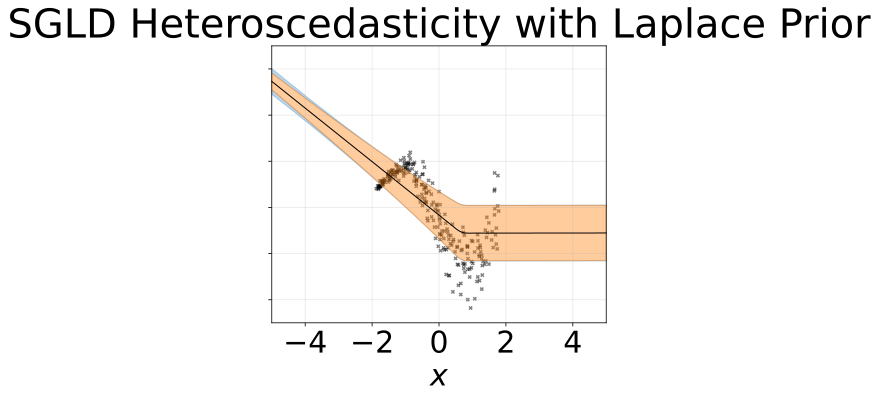

In [ ]:
print("Using %d networks for prediction" % len(nets))
samples = []
noises = []
for network in nets:
    preds = network.forward(torch.linspace(-5, 5, 200).cuda()).cpu().data.numpy()
    samples.append(preds[:, 0])
    noises.append(np.exp(preds[:, 1]))
    
samples = np.array(samples)
means = (samples.mean(axis = 0)).reshape(-1)

noises = np.array(noises)
aleatoric = (noises**2).mean(axis = 0)**0.5
epistemic = samples.var(axis = 0)**0.5
total_unc = (aleatoric**2 + epistemic**2)**0.5

c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize = (6, 5))
plt.style.use('default')
plt.scatter(x_train, y_train, s = 10, marker = 'x', color = 'black', alpha = 0.5)
plt.fill_between(np.linspace(-5, 5, 200), means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = 'Epistemic + Aleatoric')
plt.fill_between(np.linspace(-5, 5, 200), means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
plt.fill_between(np.linspace(-5, 5, 200), means - aleatoric, means + aleatoric, color = c[1], alpha = 0.4, label = 'Aleatoric')
plt.plot(np.linspace(-5, 5, 200), means, color = 'black', linewidth = 1)
plt.xlim([-5, 5])
plt.ylim([-5, 7])
plt.xlabel('$x$', fontsize=30)
plt.title('SGLD Heteroscedasticity with Laplace Prior', fontsize=40)
plt.tick_params(labelsize=30)
plt.xticks(np.arange(-4, 5, 2))
plt.yticks(np.arange(-4, 7, 2))
plt.gca().set_yticklabels([])
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)
plt.savefig('sgld_laplace_hetero.pdf', bbox_inches = 'tight')

#files.download("sgld_hetero.pdf")

plt.show()

## DP-SGLD Gaussian Prior Heter

In [ ]:
class Langevin_SGD(Optimizer):

    def __init__(self, params, lr, weight_decay=0, nesterov=False):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, weight_decay=weight_decay)
        
        super(Langevin_SGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    def step(self, closure=None):
        
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            
            weight_decay = group['weight_decay']
            
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                
                if len(p.shape) == 1 and p.shape[0] == 1:
                    p.data.add_(-group['lr'], d_p)
                    
                else:
                    if weight_decay != 0:
                        d_p.add_(weight_decay, p.data)

                    unit_noise = Variable(p.data.new(p.size()).normal_())

                    p.data.add_(-group['lr'], 0.5*d_p + unit_noise/group['lr']**0.5)

        return loss

In [ ]:
!pip install opacus
from opacus import PrivacyEngine

In [ ]:
class Langevin_Wrapper:
    def __init__(self, network, learn_rate, batch_size, no_batches, weight_decay):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = network
        self.network.cuda()
        
        self.optimizer = Langevin_SGD(self.network.parameters(), lr=self.learn_rate, weight_decay=weight_decay)
        privacy_engine = PrivacyEngine(
                self.network,
                sample_rate=batch_size/250,
                alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
                noise_multiplier=noise_multiplier,
                max_grad_norm=2/self.learn_rate/noise_multiplier)

        # clipping_norm = 100
        # self.optimizer = torch.optim.SGD(self.network.parameters(), lr=self.learn_rate, weight_decay=weight_decay)
        # privacy_engine = PrivacyEngine(
        #         self.network,
        #         sample_rate=batch_size/250,
        #         alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
        #         noise_multiplier=1/np.sqrt(self.learn_rate/self.batch_size)/clipping_norm,
        #         max_grad_norm=clipping_norm)

        privacy_engine.attach(self.optimizer)

        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        
        output = self.network(x)
        loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)
        
        loss.backward()
        self.optimizer.step()

        return loss,output[:, :1]
    
    
    def test_loss(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)
        
        output = self.network(x)
        loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)

        return loss

 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  149.608
Epoch:   50, Train loss =  130.751
Epoch:  100, Train loss =  112.261
Epoch:  150, Train loss =   98.225
Epoch:  200, Train loss =  178.389
Using 1 networks for prediction


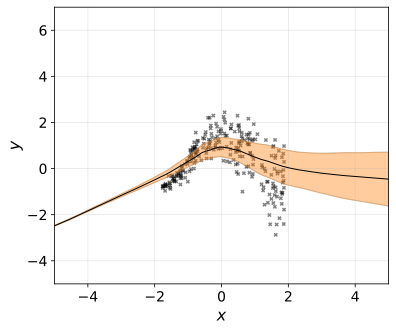

 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  164.548
Epoch:   50, Train loss =  124.741
Epoch:  100, Train loss =  183.712
Epoch:  150, Train loss =  215.045
Epoch:  200, Train loss =  151.875


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  165.675
Epoch:   50, Train loss =  209.055
Epoch:  100, Train loss =  314.166
Epoch:  150, Train loss =  442.780
Epoch:  200, Train loss =  283.678


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  116.373
Epoch:   50, Train loss =  218.168
Epoch:  100, Train loss =  111.178
Epoch:  150, Train loss =   95.163
Epoch:  200, Train loss =   48.433


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  218.827
Epoch:   50, Train loss =  333.548
Epoch:  100, Train loss =   73.062
Epoch:  150, Train loss =   91.845
Epoch:  200, Train loss =  448.712


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  153.697
Epoch:   50, Train loss =  141.025
Epoch:  100, Train loss =   72.338
Epoch:  150, Train loss =   44.349
Epoch:  200, Train loss =   60.680


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  148.721
Epoch:   50, Train loss =  294.100
Epoch:  100, Train loss =  430.687
Epoch:  150, Train loss =   64.078
Epoch:  200, Train loss =  260.575


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  167.848
Epoch:   50, Train loss =   25.805
Epoch:  100, Train loss =  -44.737
Epoch:  150, Train loss =  162.412
Epoch:  200, Train loss =   13.456


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  156.826
Epoch:   50, Train loss =  115.051
Epoch:  100, Train loss =  193.592
Epoch:  150, Train loss =  105.535
Epoch:  200, Train loss =   57.134


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  120.745
Epoch:   50, Train loss =  -28.480
Epoch:  100, Train loss =  267.719
Epoch:  150, Train loss =   67.663
Epoch:  200, Train loss =   83.294


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  117.330
Epoch:   50, Train loss =   85.282
Epoch:  100, Train loss =   26.045
Epoch:  150, Train loss =  216.380
Epoch:  200, Train loss =   81.584


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  100.169
Epoch:   50, Train loss =  152.870
Epoch:  100, Train loss =   77.591
Epoch:  150, Train loss =  170.030
Epoch:  200, Train loss =  165.796


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =   98.186
Epoch:   50, Train loss =  176.815
Epoch:  100, Train loss =   22.511
Epoch:  150, Train loss =  533.579
Epoch:  200, Train loss =  -22.970


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  105.150
Epoch:   50, Train loss =   85.702
Epoch:  100, Train loss =  107.630
Epoch:  150, Train loss =   45.773
Epoch:  200, Train loss =   87.892


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  100.925
Epoch:   50, Train loss =  149.584
Epoch:  100, Train loss =   55.350
Epoch:  150, Train loss =  127.717
Epoch:  200, Train loss =   49.019


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =   97.045
Epoch:   50, Train loss =  502.182
Epoch:  100, Train loss =   49.919
Epoch:  150, Train loss =  160.623
Epoch:  200, Train loss =   93.277


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  109.137
Epoch:   50, Train loss =  -49.926
Epoch:  100, Train loss =   52.022
Epoch:  150, Train loss =   92.863
Epoch:  200, Train loss =   -5.414


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  111.889
Epoch:   50, Train loss =   37.983
Epoch:  100, Train loss =  103.199
Epoch:  150, Train loss =  128.565
Epoch:  200, Train loss =   88.555


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =   79.735
Epoch:   50, Train loss =  187.384
Epoch:  100, Train loss =  158.093
Epoch:  150, Train loss =  160.939
Epoch:  200, Train loss =  578.069


 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:646: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  103.033
Epoch:   50, Train loss =   23.315
Epoch:  100, Train loss =   17.348
Epoch:  150, Train loss =   11.662
Epoch:  200, Train loss =  188.187
[0.7098755736131469, 0.6106938775519146, 0.45725374406675473, 0.503049929223701, 0.8613716491948362, 0.5832311617042192, 0.6746940409702975, 0.4123022810302746, 0.5080119718179843, 0.35774874778982074, 0.48818289042023594, 0.4490981458731713, 0.5138526950964792, 0.5795283605983869, 0.6866188610684733, 0.6760814049884148, 0.445814275568945, 0.4881252197008813, 0.7897166294559346, 0.491894318689955] 0.5109323334572318


In [ ]:
np.random.seed(5)
average_mse = []
for iter in range(20):
  no_points = 400
  lengthscale = 1
  variance = 1.0
  sig_noise = 0.3
  x = np.random.uniform(-3, 3, no_points)[:, None]
  x.sort(axis=0)


  k = GPy.kern.RBF(input_dim=1, variance=variance, lengthscale=lengthscale)
  C = k.K(x, x) + np.eye(no_points)*(x + 2)**2*sig_noise**2

  y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
  y = (y - y.mean())
  x_train = x[75:325]
  y_train = y[75:325]


  best_net, best_loss = None, float('inf')
  num_nets, nets, losses = 1, [], []
  mix_epochs, burnin_epochs = 50, 150
  num_epochs = mix_epochs*num_nets + burnin_epochs + 1

  batch_size, nb_train = len(x_train), len(x_train)
  noise_multiplier=10
  net = Langevin_Wrapper(network=Langevin_Model(input_dim=1, output_dim=1, num_units=200),learn_rate=2.5e-4, batch_size=batch_size, no_batches=1, weight_decay=50)
  
  for i in range(num_epochs):
      
      loss,y_hat = net.fit(x_train, y_train)
      
      if i % mix_epochs == 0:
          print('Epoch: %4d, Train loss = %8.3f' % (i, loss.cpu().data.numpy()))
          
      if i % 100 == 0 and i > burnin_epochs: nets.append(copy.deepcopy(net.network))
  average_mse.append(np.power((y_hat.cpu().data.numpy()-y_train),2).mean())
  if iter==0:
      print("Using %d networks for prediction" % len(nets))
      samples = []
      noises = []
      for network in nets:
          preds = network.forward(torch.linspace(-5, 5, 200).cuda()).cpu().data.numpy()
          samples.append(preds[:, 0])
          noises.append(np.exp(preds[:, 1]))
          
      samples = np.array(samples)

      means = (samples.mean(axis = 0)).reshape(-1)
      noises = np.array(noises)
      aleatoric = (noises**2).mean(axis = 0)**0.5
      epistemic = samples.var(axis = 0)**0.5
      total_unc = (aleatoric**2 + epistemic**2)**0.5

      c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

      plt.figure(figsize = (6, 5))
      plt.style.use('default')
      plt.scatter(x_train, y_train, s = 10, marker = 'x', color = 'black', alpha = 0.5)
      plt.fill_between(np.linspace(-5, 5, 200), means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = 'Epistemic + Aleatoric')
      plt.fill_between(np.linspace(-5, 5, 200), means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
      plt.fill_between(np.linspace(-5, 5, 200), means - aleatoric, means + aleatoric, color = c[1], alpha = 0.4, label = 'Aleatoric')
      plt.plot(np.linspace(-5, 5, 200), means, color = 'black', linewidth = 1)
      plt.xlim([-5, 5])
      plt.ylim([-5, 7])
      plt.xlabel('$x$', fontsize=16)
      plt.ylabel('$y$', fontsize=16)
      #plt.tick_params(labelsize=30)
      plt.xticks(np.arange(-4, 5, 2),fontsize=14)
      plt.yticks(np.arange(-4, 7, 2),fontsize=14)
      #plt.gca().set_yticklabels([])
      plt.gca().yaxis.grid(alpha=0.3)
      plt.gca().xaxis.grid(alpha=0.3)
      plt.savefig('dpsgld_hetero.pdf', bbox_inches = 'tight')

      #files.download("dpsgld_hetero.pdf")

      plt.show()

print(average_mse,np.median(average_mse))

## DP-SGLD Laplace Prior Heter

In [ ]:
class Langevin_SGD(Optimizer):

    def __init__(self, params, lr, weight_decay=0, nesterov=False):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, weight_decay=weight_decay)
        
        super(Langevin_SGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    def step(self, closure=None):
        
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            
            weight_decay = group['weight_decay']
            
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                
                if len(p.shape) == 1 and p.shape[0] == 1:
                    p.data.add_(-group['lr'], d_p)
                    
                else:
                    if weight_decay != 0:
                        d_p.add_(weight_decay, torch.sign(p.data))

                    unit_noise = Variable(p.data.new(p.size()).normal_())

                    p.data.add_(-group['lr'], 0.5*d_p + unit_noise/group['lr']**0.5)

        return loss

In [ ]:
noise_multiplier = 1.3

In [ ]:
class Langevin_Wrapper:
    def __init__(self, network, learn_rate, batch_size, no_batches, weight_decay):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = network
        self.network.cuda()
        
        self.optimizer = Langevin_SGD(self.network.parameters(), lr=self.learn_rate, weight_decay=weight_decay)
        privacy_engine = PrivacyEngine(
                self.network,
                sample_rate=batch_size/400,
                alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
                noise_multiplier=noise_multiplier,
                max_grad_norm=2/self.learn_rate/noise_multiplier)
        privacy_engine.attach(self.optimizer)

        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        
        output = self.network(x)
        loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)
        
        loss.backward()
        self.optimizer.step()

        return loss
    
    
    def test_loss(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)
        
        output = self.network(x)
        loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)

        return loss

In [ ]:
np.random.seed(2)
no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3
x = np.random.uniform(-3, 3, no_points)[:, None]
x.sort(axis=0)


k = GPy.kern.RBF(input_dim=1, variance=variance, lengthscale=lengthscale)
C = k.K(x, x) + np.eye(no_points)*(x + 2)**2*sig_noise**2

y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
y = (y - y.mean())
x_train = x[75:325]
y_train = y[75:325]


best_net, best_loss = None, float('inf')
num_nets, nets, losses = 50, [], []
mix_epochs, burnin_epochs = 100, 1000
num_epochs = mix_epochs*num_nets + burnin_epochs + 1

batch_size, nb_train = len(x_train), len(x_train)

net = Langevin_Wrapper(network=Langevin_Model(input_dim=1, output_dim=1, num_units=10),learn_rate=1e-4, batch_size=batch_size, no_batches=1, weight_decay=20)

for i in range(num_epochs):
    
    loss = net.fit(x_train, y_train)
    
    if i % mix_epochs == 0:
        print('Epoch: %4d, Train loss = %8.3f' % (i, loss.cpu().data.numpy()))
        
    if i % 100 == 0 and i > burnin_epochs: nets.append(copy.deepcopy(net.network))

 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:523: UserWarning:A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
 /usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:195: UserWarning:Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch:    0, Train loss =  301.405
Epoch:  100, Train loss =  249.008
Epoch:  200, Train loss =  250.089
Epoch:  300, Train loss =  250.915
Epoch:  400, Train loss =  250.419
Epoch:  500, Train loss =  250.570
Epoch:  600, Train loss =  255.543
Epoch:  700, Train loss =  252.387
Epoch:  800, Train loss =  251.755
Epoch:  900, Train loss =  252.125
Epoch: 1000, Train loss =  253.477
Epoch: 1100, Train loss =  251.757
Epoch: 1200, Train loss =  252.164
Epoch: 1300, Train loss =  253.295
Epoch: 1400, Train loss =  254.098
Epoch: 1500, Train loss =  253.326
Epoch: 1600, Train loss =  251.818
Epoch: 1700, Train loss =  253.052
Epoch: 1800, Train loss =  253.216
Epoch: 1900, Train loss =  251.214
Epoch: 2000, Train loss =  252.621
Epoch: 2100, Train loss =  251.318
Epoch: 2200, Train loss =  255.993
Epoch: 2300, Train loss =  255.584
Epoch: 2400, Train loss =  251.088
Epoch: 2500, Train loss =  257.526
Epoch: 2600, Train loss =  252.046
Epoch: 2700, Train loss =  252.111
Epoch: 2800, Train l

Using 50 networks for prediction


 /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning:Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


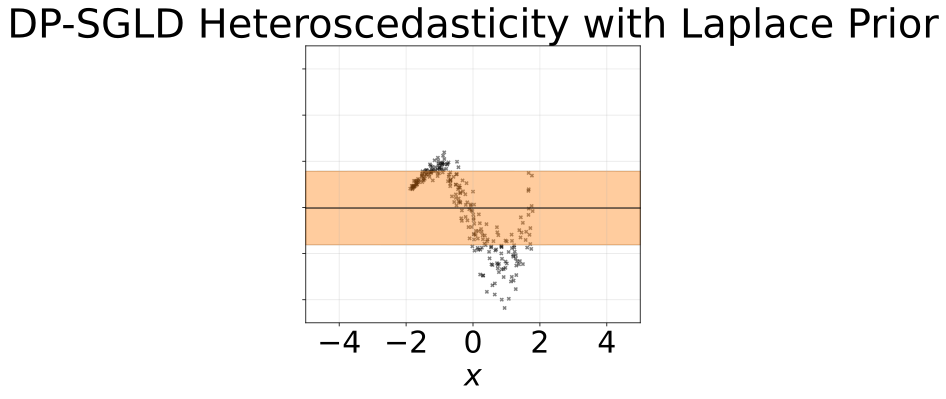

In [ ]:
print("Using %d networks for prediction" % len(nets))
samples = []
noises = []
for network in nets:
    preds = network.forward(torch.linspace(-5, 5, 200).cuda()).cpu().data.numpy()
    samples.append(preds[:, 0])
    noises.append(np.exp(preds[:, 1]))
    
samples = np.array(samples)
means = (samples.mean(axis = 0)).reshape(-1)

noises = np.array(noises)
aleatoric = (noises**2).mean(axis = 0)**0.5
epistemic = samples.var(axis = 0)**0.5
total_unc = (aleatoric**2 + epistemic**2)**0.5

c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize = (6, 5))
plt.style.use('default')
plt.scatter(x_train, y_train, s = 10, marker = 'x', color = 'black', alpha = 0.5)
plt.fill_between(np.linspace(-5, 5, 200), means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = 'Epistemic + Aleatoric')
plt.fill_between(np.linspace(-5, 5, 200), means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
plt.fill_between(np.linspace(-5, 5, 200), means - aleatoric, means + aleatoric, color = c[1], alpha = 0.4, label = 'Aleatoric')
plt.plot(np.linspace(-5, 5, 200), means, color = 'black', linewidth = 1)
plt.xlim([-5, 5])
plt.ylim([-5, 7])
plt.xlabel('$x$', fontsize=30)
plt.title('DP-SGLD Heteroscedasticity with Laplace Prior', fontsize=40)
plt.tick_params(labelsize=30)
plt.xticks(np.arange(-4, 5, 2))
plt.yticks(np.arange(-4, 7, 2))
plt.gca().set_yticklabels([])
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)
plt.savefig('dp_sgld_laplace_hetero.pdf', bbox_inches = 'tight')

#files.download("sgld_hetero.pdf")

plt.show()